#Statistical Machine Learning
##Project 2

This notebook collects all the code required for re-producing the analysis documented in the report for project 2.

In [5]:
#Import the required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from math import sqrt
from scipy.stats import linregress
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap

#Set up inline plotting
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

#Load the data. 
#Data can be re-generated using generate_data.py and google_distances.py.
data     = pd.read_pickle("./data_frames/clean_data.pkl")
geo_data = pd.read_pickle("./data_frames/google_distances.pkl")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##Parts A1 & A2 - Similarity Measures

First we specify the similarity measure we'll be working with, and generate a suitable feature representation for each instance (region) in the data set. 

In [6]:
#This sets the similarity measure we'll be working with
#Refer to the report for more info on available measures
measure = "wealth_gap"

#Convenience data structure for pulling the columns associated
#with each similarity measure out of the data.
available_measures = {
    "land_utilisation":(
        ["land_use"],
        [col for col in data["land_use"] if (col[-3:] == "pct")]
    ),
    "wealth_gap":(
        ["socio_demographic"],
        ["pct_household_income_less_600_week", 
         "pct_personal_income_less_400_week", 
         "isrd_score_avg", "unemployed", 
         "pct_persons_dnc_year_12"]
    ),
    "population_age_diversity":(
        ["diversity", "2012_population"],
        [["aboriginal_tsi_persons",
          "born_overseas",
          "born_non_english_speaking_country",
          "speak_lote_at_home",
          "persons_poor_english"],
         [col for col in data["2012_population"] 
          if (col not in ["total_persons"]) and (col[-3:] != "pct")]]
    )
}

#Gets the data we need for computing the chosen similarity measure
features = []
if len(available_measures[measure][0]) > 1:
    for i in range(0, len(available_measures[measure][0])):
        features += [
            (available_measures[measure][0][i], col) 
            for col in available_measures[measure][1][i]
        ]
else:
    features = [
        (available_measures[measure][0][0], col) 
        for col in available_measures[measure][1]
    ]

Next, we profile the similarity measure using a combination of K-Means clustering and the Isomap algorithm.

Clustering consists of the following process:
1. Cluster the data using a range of different K values.
2. Plot the discrepancy function for each clustering model against the associated value of K.
3. Set the value of K using the "kink" or "elbow" in the resulting graph (REF).
4. Re-cluster the data using the identified K-value.
5. Reduce the dimensionality of the data using the isomap algorithm and visualise on a 2D scatter plot.

In [7]:
#Choose a range of target values/init empty list for target function values
k_values = range(1, len(data.index))
w_values = []

#Iteratively compute w for each value of k
for k in k_values:
    km = KMeans(n_clusters=k)    
    km.fit(data[features].fillna(0))
    w_values.append(km.inertia_)

#Plot the values
plt.plot(k_values, w_values)

KeyError: "[('socio_demographic', 'pct_personal_income_less_400_week')] not in index"

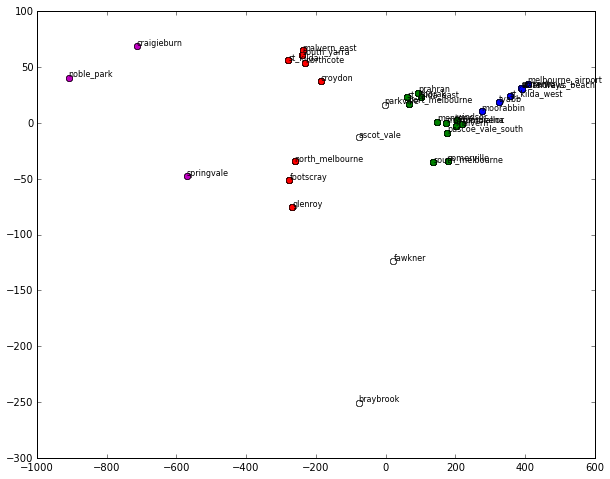

In [19]:
#Re-cluster using the graph above and store the clusters in the feature representation
km = KMeans(n_clusters=5)

feature_set = pd.DataFrame(data[features].fillna(0))
feature_set["cluster"] = km.fit_predict(feature_set)

isomap = Isomap(n_components=2)

reduced = pd.DataFrame(isomap.fit_transform(feature_set), index=feature_set.index, columns=["x", "y"])
reduced["cluster"] = feature_set["cluster"]

#Label the clusters
for place in reduced.index:
    plt.annotate(
        place, (
            reduced.loc[place]["x"] + 1, 
            reduced.loc[place]["y"] + 1
        ), size=8
    )

#Styling params for clusters
styling = {
    0:"ro",
    1:"go",
    2:"bo",
    3:"mo",
    4:"wo",
    5:"yo",
    6:"co",
    7:"ko",
    8:"w*",
    9:"w^",
}

#Plot the reduced data set
for cluster in reduced["cluster"]:
    plt.plot(
        reduced[reduced["cluster"] == cluster]["x"], 
        reduced[reduced["cluster"] == cluster]["y"],
        styling[cluster]
    )
#plt.savefig("2012_population_manifold.png")

##Part A3 - Comparing Geographically Similar Regions

To compare geographically similar regions, we take the pair-wise similarity between two feature vectors (where the feature vectors are defined as described above) and plotting this against the pair-wise distance between the regiouns represented by those same vectors.

In [25]:
####################
# Helper Functions #
####################

#Defines the euclidean distance between two vectors a and b
def euclidean(a, b):
    return sum( sqrt((ai - bi)**2) for ai,bi in zip(a,b) )

#Defines the cosine similarity between two vectors a and b
def vector_norm(a):
    return sqrt(sum(ai**2 for ai in a))

def dot_product(a, b):
    return sum([ai*bi for ai,bi in zip(a,b)])

def cosine(a, b):
    return dot_product(a, b) / (vector_norm(a) * vector_norm(b))

#Converts a distance matrix into a list of distance triples - (source, destination, distance)
def distance_triple(dataframe):
    distances = []
    for source,destinations in dataframe.to_dict().items():
        for destination,distance in destinations.items():
            if destination != source:
                distances.append((source, destination, distance))
    return distances

In [26]:
#Create pair-wise distance/similarity matrices from the features

#Creates a pair-wise distance matrix form the input data
euclidean_distances = pd.DataFrame(
    index=feature_set.index,
    columns=feature_set.index,
    dtype=float
).fillna(0.0)

for suburb in feature_set.index:
    u = feature_set.loc[suburb]
    for compare_to in [sub for sub in feature_set.index if sub != suburb]:
        v = feature_set.loc[compare_to]
        euclidean_distances.loc[suburb][compare_to] = euclidean(u, v)

#Creates a pair-wise similarity matrix from the input data
cosine_distances = pd.DataFrame(
    index=feature_set.index,
    columns=feature_set.index,
    dtype=float
).fillna(0.0)

for suburb in feature_set.index:
    u = feature_set.loc[suburb]
    for compare_to in [sub for sub in feature_set.index if sub != suburb]:
        v = feature_set.loc[compare_to]
        cosine_distances.loc[suburb][compare_to] = cosine(u, v)

#Convert the distance/similarity matrices into a form suitable for plotting
actual_distances = distance_triple(geo_data)
euclidean_distances = distance_triple(euclidean_distances)
cosine_distances = distance_triple(cosine_distances)

In [27]:
#Plot Euclidean distance vs actual distance between pairs of regions
plt.xlabel("Actual Distance (m)")
plt.ylabel("Euclidean Distance (between feature vectors)")
plt.title("Land Use Distance vs Geographical Distance Between Pairs of Suburbs", size=12)

plt.scatter(
    [dist[2] for dist in actual_distances],
    [dist[2] for dist in euclidean_distances],
)

In [28]:
#Plot cosine similarity vs actual distance between pairs of regions
plt.xlabel("Actual Distance (m)")
plt.ylabel("Cosine Similarity (between feature vectors)")
plt.title("Population Age and Diversity Similarity vs Geographical Distance Between Pairs of Suburbs", size=12)

plt.scatter(
    [dist[2] for dist in actual_distances],
    [dist[2] for dist in cosine_distances],
)

##Part B - Trends, Patterns and Other Anomolies

The first trend we observe is that development of public services hasn't kept up with population growth in a number of key growth areas (areas experiencing abnormally high levels of growth). We can observe that many of the areas where service development isn't keeping up are also those that tend to experience higher levels of impoverishment.

In [42]:
#Sum up the services available in each region
services = pd.DataFrame(data["services"][[col for col in data["services"].columns if col not in ["aged_care_services_high", "aged_care_services_low", "aged_care_srs"]]])
services["sum"] = services.sum(axis=1)

#Exclude Footscray as it's a clear outlier
no_footscray = [place for place in data.index if place != "footscray"]
x = services.loc[no_footscray]["sum"]
y = data.loc[no_footscray]["socio_demographic"]["occupied_private_dwellings"]

#Fit a simple linear model
m,c,r,_,_ = linregress(x, y)

#Annotate the plot
for place in data.index:
    plt.annotate(
        place, (
            services.loc[place]["sum"] + 5, 
            data.loc[place]["socio_demographic"]["occupied_private_dwellings"] - 5
        ), size=8
    )

#Create the plot
plt.xlabel("Total services, excluding aged care")
plt.ylabel("Number of households")
plt.annotate("y = m*{:.2f} + {:.2f}\nr^2 = {}".format(m,c,r), (100, 500), size=12)
plt.scatter(services["sum"], data["socio_demographic"]["occupied_private_dwellings"])
plt.plot(x, [xi * m + c for xi in x])

In [43]:
#Tabulate the total growth of each region (in persons)
growth = pd.DataFrame(data["2012_population"] - data["2007_population"])
growth.sort("total_persons")["total_persons"]

st_kilda_west         -218.099954
sorrento               -62.000000
toorak                 -35.333265
st_andrews_beach        87.413799
moorabbin              116.000210
somerville             199.347506
murrumbeena            282.000076
malvern_east           345.999988
windsor                468.000000
mordialloc             492.666664
pascoe_vale_south      601.133362
st_kilda_east          667.177946
malvern                695.455675
tyabb                  700.383613
fawkner                767.000255
prahran                960.000045
parkville             1002.799968
south_melbourne       1021.946512
port_melbourne        1214.085714
ascot_vale            1219.875070
braybrook             1223.000096
mentone               1436.425771
waterways             1638.578974
glenroy               1665.207377
northcote             1698.999951
north_melbourne       1859.700000
croydon               1909.361149
springvale            1979.000134
footscray             2058.333353
st_kilda      

The second trend we observe is that there is a direct correlation between the number of people born overseas and the amount of disadvantage in a given region.

In [44]:
x = data["diversity"]["born_overseas"]
y = data["socio_demographic"]["household_income_less_600_week"]

#Fit a simple linear model
m,c,r,_,_ = linregress(x, y)

#Annotate the plot
for place in data.index:
    plt.annotate(
        place, (
            x.loc[place],
            y.loc[place]
        ), size=8
    )

#Create the plot
plt.xlabel("Number of households with income less than 600/week")
plt.ylabel("Number of residents born overseas")
plt.annotate("y = m*{:.2f} + {:.2f}\nr^2 = {}".format(m,c,r), (12000,0), size=12)
plt.scatter(x, y)
plt.plot(x, [xi * m + c for xi in x])